# Initialization

## Import

### Import Modules

In [1]:
import gc
import time

import numpy as np
from matplotlib import pyplot as plt

from tasks.optic_disc_cup.datasets import DrishtiDataset, RimOneDataset
from tasks.optic_disc_cup.metrics import calc_disc_cup_iou
from config.config_type import AllConfig, DataConfig, DataTuneConfig, LearnConfig, WeaselConfig
from data.dataset_loaders import DatasetLoaderParamSimple
from data.types import SparsityValue
from learners.protoseg import ProtoSegLearner
from learners.weasel import WeaselLearner
from models.u_net import UNet

from torch import cuda

plt.style.use('dark_background')

### Autoreload Import

In [2]:
%reload_ext autoreload
%autoreload 1
%aimport config.config_type
%aimport models.u_net
%aimport data.types, data.few_sparse_dataset, data.dataset_loaders
%aimport learners.learner, learners.weasel, learners.protoseg
%aimport tasks.optic_disc_cup.datasets, tasks.optic_disc_cup.metrics

In [3]:
%autoreload now

## All Config

### Short Training

In [4]:
data_config: DataConfig = {
    'num_classes': 3,
    'num_channels': 3,
    'num_workers': 0,
    'batch_size': 1,
    'resize_to': (256, 256)
}

data_tune_config: DataTuneConfig = {
    'shot_list': [5],
    'sparsity_dict': {
        'point': [50],
        'grid': [10],
        'contour': [1],
        'skeleton': [1],
        'region': [1]
    }
}

learn_config: LearnConfig = {
    'should_resume': False,
    'use_gpu': True,
    'num_epochs': 8,
    'optimizer_lr': 1e-3,
    'optimizer_weight_decay': 5e-5,
    'optimizer_momentum': 0.9,
    'scheduler_step_size': 150,
    'scheduler_gamma': 0.2,
    'tune_freq': 4,
    'exp_name': ''
}

weasel_config: WeaselConfig = {
    'use_first_order': False,
    'update_param_step_size': 0.3,
    'tune_epochs': 6,
    'tune_test_freq': 3
}

all_config: AllConfig = {
    'data': data_config,
    'data_tune': data_tune_config,
    'learn': learn_config,
    'weasel': weasel_config
}

### Long Training

In [5]:
# data_config: DataConfig = {
#     'num_classes': 3,
#     'num_channels': 3,
#     'num_workers': 0,
#     'batch_size': 1,
#     'resize_to': (256, 256)
# }

# data_tune_config: DataTuneConfig = {
#     'shot_list': [20],
#     'sparsity_dict': {
#         'point': [50],
#         'grid': [10],
#         'contour': [1],
#         'skeleton': [1],
#         'region': [1]
#     }
# }

# learn_config: LearnConfig = {
#     'should_resume': False,
#     'use_gpu': True,
#     'num_epochs': 200,
#     'optimizer_lr': 1e-3,
#     'optimizer_weight_decay': 5e-5,
#     'optimizer_momentum': 0.9,
#     'scheduler_step_size': 150,
#     'scheduler_gamma': 0.2,
#     'tune_freq': 40,
#     'exp_name': ''
# }

# weasel_config: WeaselConfig = {
#     'use_first_order': False,
#     'update_param_step_size': 0.3,
#     'tune_epochs': 40,
#     'tune_test_freq': 8
# }

# all_config: AllConfig = {
#     'data': data_config,
#     'data_tune': data_tune_config,
#     'learn': learn_config,
#     'weasel': weasel_config
# }

# Dataset Exploration

## RIM-ONE

### Create Dataset

In [6]:
rim_one_sparsity_params: dict = {
    'point_dot_size': 1,
    'grid_dot_size': 1,
    'contour_radius_dist': 4,
    'contour_radius_thick': 2,
    'skeleton_radius_thick': 4,
    'region_compactness': 0.5
}

rim_one_data = RimOneDataset(
    mode='train',
    num_classes=3,
    num_shots=5,
    resize_to=(256, 256),
    split_seed=0,
    sparsity_params=rim_one_sparsity_params
)

### Check Sparse Masks

C:\Users\pandega\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


(256, 256, 3) 197 4 r3_G-2-R_left_half
(256, 256) int8 [0 1 2]


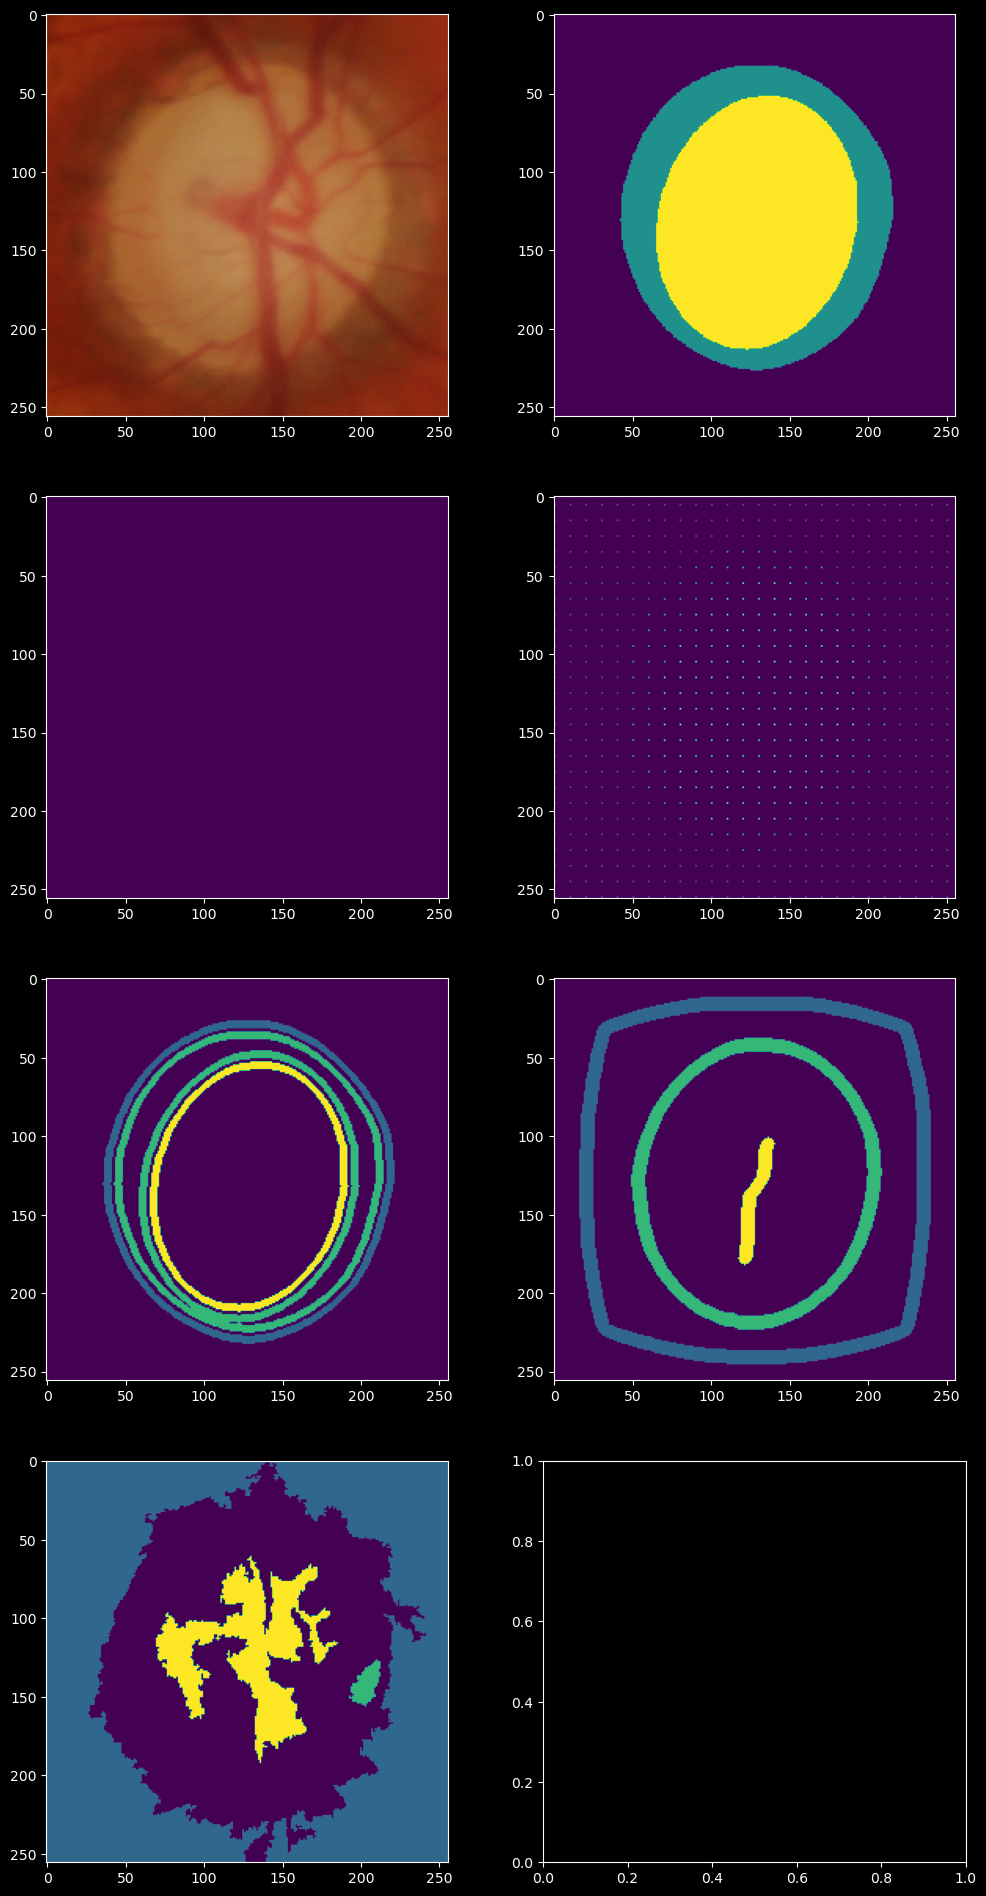

In [7]:
sparsity_values: dict[str, SparsityValue] = {
    'point': 50,
    'grid': 10,
    'contour': 1,
    'skeleton': 1,
    'region': 1,
}
image, mask, sparse_masks, image_filename = rim_one_data.get_data_with_sparse_all(0, sparsity_values)
print(image.shape, image.max(), image.min(), image_filename)
print(mask.shape, mask.dtype, np.unique(mask))

n_rows = int(np.ceil(len(sparse_masks) / 2)) + 1 
_, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows*6))
axs = axs.flat
axs[0].imshow(image)
axs[1].imshow(mask)
for i, sparsity in enumerate(sparse_masks):
    axs[i+2].imshow(sparse_masks[sparsity])

### Check Others

In [8]:
# image_sizes = []
# for image_path, mask_path in rim_one_data.get_all_data_path():
#     image, _ = rim_one_data.read_image_mask(image_path, mask_path)
#     image_sizes.append(image.shape)
# 
# image_sizes = np.array(image_sizes)
# 
# print(np.unique(image_sizes[:,0], return_counts=True))
# print(image_sizes[:,0].min(), image_sizes[:,0].max())
# print(np.unique(image_sizes[:,1], return_counts=True))
# print(image_sizes[:,1].min(), image_sizes[:,1].max())

## DRISHTI

### Create Dataset

In [9]:
drishti_sparsity_params: dict = {
    'point_dot_size': 1,
    'grid_dot_size': 1,
    'contour_radius_dist': 4,
    'contour_radius_thick': 1,
    'skeleton_radius_thick': 3,
    'region_compactness': 0.5
}

drishti_data = DrishtiDataset(
    mode='train',
    num_classes=3,
    num_shots=5,
    resize_to=(256, 256),
    split_seed=0,
    sparsity_params=drishti_sparsity_params
)

### Check Sparse Masks

(256, 256, 3) 187 9 045_cropped
(256, 256) int8 [0 1 2]


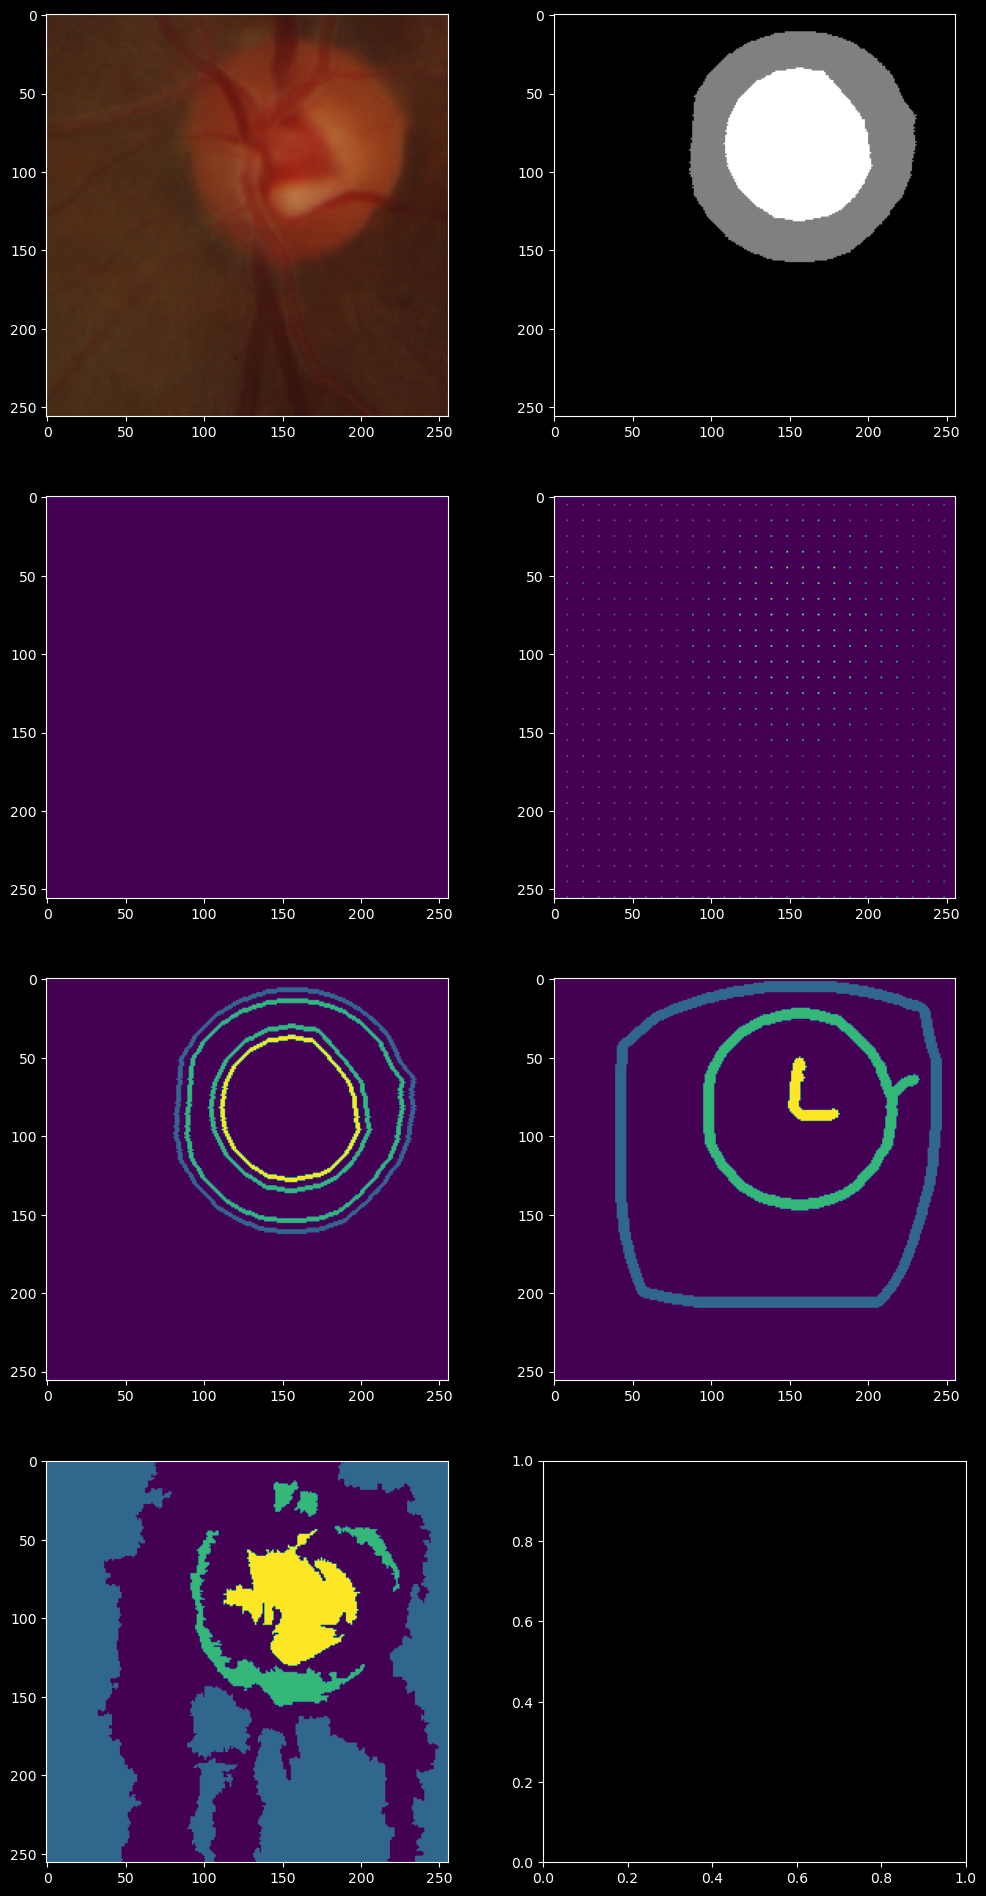

In [10]:
sparsity_values: dict[str, SparsityValue] = {
    'point': 50,
    'grid': 10,
    'contour': 1,
    'skeleton': 1,
    'region': 1,
}
image, mask, sparse_masks, image_filename = drishti_data.get_data_with_sparse_all(1, sparsity_values)
print(image.shape, image.max(), image.min(), image_filename)
print(mask.shape, mask.dtype, np.unique(mask))

n_rows = int(np.ceil(len(sparse_masks) / 2)) + 1
_, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows*6))
axs = axs.flat
axs[0].imshow(image)
axs[1].imshow(mask, cmap='gray')
for i, sparsity in enumerate(sparse_masks):
    axs[i+2].imshow(sparse_masks[sparsity])

### Check Others

In [11]:
# image_sizes = []
# for image_path, mask_path in drishti_data.get_all_data_path():
#     image, _ = rim_one_data.read_image_mask(image_path, mask_path)
#     image_sizes.append(image.shape)
# 
# image_sizes = np.array(image_sizes)
# 
# print(np.unique(image_sizes[:,0], return_counts=True))
# print(image_sizes[:,0].min(), image_sizes[:,0].max())
# print(np.unique(image_sizes[:,1], return_counts=True))
# print(image_sizes[:,1].min(), image_sizes[:,1].max())

# Weasel Learner

## Initialization

### Update Config

In [12]:
all_config['data']['batch_size'] = 3
all_config['learn']['exp_name'] = 'WS RO-DR short dummy'
# all_config['learn']['exp_name'] = 'WS RO-DR short v2'
# all_config['learn']['exp_name'] = 'weasel_long_rimone_to_drishti'

### Define Loader Params

In [13]:
rim_one_meta_loader_params: DatasetLoaderParamSimple = {
    'dataset_class': RimOneDataset,
    'dataset_kwargs': {
        'split_seed': 0,
        'split_test_size': 0.2,
        'sparsity_mode': 'random',
        'sparsity_value': 'random',
        'sparsity_params': rim_one_sparsity_params
    },
    'max_iterations': 8
}

drishti_tune_loader_params: DatasetLoaderParamSimple = {
    'dataset_class': DrishtiDataset,
    'dataset_kwargs': {
        'split_seed': 0,
        'split_test_size': 0.2,
        'sparsity_params': drishti_sparsity_params
    }
}

### Create Model

In [19]:
net = UNet(all_config['data']['num_channels'], all_config['data']['num_classes'])

n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('# of parameters: ' + str(n_params))

# of parameters: 1928483


### Create Learner

In [20]:
learner = WeaselLearner(net, all_config, [rim_one_meta_loader_params], drishti_tune_loader_params, calc_disc_cup_iou)

## Learning

In [21]:
learner.learn()

Start learning ...

Using GPU with total memory 2048MiB, 0.00% is already used
Ep: 1/8, data: 1/1, it: 1/8, loss: 0.9836
Ep: 1/8, data: 1/1, it: 2/8, loss: 0.6832
Ep: 1/8, data: 1/1, it: 3/8, loss: 1.6029
Ep: 1/8, data: 1/1, it: 4/8, loss: 0.6813
Ep: 1/8, data: 1/1, it: 5/8, loss: 0.9387
Ep: 1/8, data: 1/1, it: 6/8, loss: 0.9804
Ep: 1/8, data: 1/1, it: 7/8, loss: 0.7132
Ep: 1/8, data: 1/1, it: 8/8, loss: 0.8341
Ep: 1/8, avg loss: 0.9272
Ep: 2/8, data: 1/1, it: 1/8, loss: 1.0141
Ep: 2/8, data: 1/1, it: 2/8, loss: 0.7684
Ep: 2/8, data: 1/1, it: 3/8, loss: 1.0262
Ep: 2/8, data: 1/1, it: 4/8, loss: 0.6283
Ep: 2/8, data: 1/1, it: 5/8, loss: 0.9057
Ep: 2/8, data: 1/1, it: 6/8, loss: 0.5912
Ep: 2/8, data: 1/1, it: 7/8, loss: 0.7619
Ep: 2/8, data: 1/1, it: 8/8, loss: 0.7433
Ep: 2/8, avg loss: 0.8049
Ep: 3/8, data: 1/1, it: 1/8, loss: 0.5066
Ep: 3/8, data: 1/1, it: 2/8, loss: 0.6454
Ep: 3/8, data: 1/1, it: 3/8, loss: 0.6394
Ep: 3/8, data: 1/1, it: 4/8, loss: 0.5443
Ep: 3/8, data: 1/1, it: 5/8, 

In [22]:
learner.remove_log_handlers()

del net
del learner

gc.collect()
cuda.empty_cache()

In [23]:
time.sleep(60)

# Protoseg Learner

## Initialization

### Update Config

In [24]:
all_config['data']['batch_size'] = 5
# all_config['learn']['should_resume'] = True
all_config['learn']['exp_name'] = 'PS RO-DR short dummy'
# all_config['learn']['exp_name'] = 'PS RO-DR short v2'
# all_config['learn']['exp_name'] = 'protoseg_long_rimone_to_drishti'

### Define Loader Params

In [25]:
rim_one_meta_loader_params: DatasetLoaderParamSimple = {
    'dataset_class': RimOneDataset,
    'dataset_kwargs': {
        'split_seed': 0,
        'split_test_size': 0.2,
        'sparsity_mode': 'random',
        'sparsity_value': 'random',
        'sparsity_params': rim_one_sparsity_params
    },
    'max_iterations': 8
}

drishti_tune_loader_params: DatasetLoaderParamSimple = {
    'dataset_class': DrishtiDataset,
    'dataset_kwargs': {
        'split_seed': 0,
        'split_test_size': 0.2,
        'sparsity_params': drishti_sparsity_params
    }
}

### Create Model

In [26]:
net = UNet(all_config['data']['num_channels'], all_config['data']['num_classes'])

n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('# of parameters: ' + str(n_params))

# of parameters: 1928483


### Create Learner

In [27]:
learner = ProtoSegLearner(net, all_config, [rim_one_meta_loader_params], drishti_tune_loader_params, calc_disc_cup_iou)

## Learning

In [28]:
learner.learn()

Start learning ...

Using GPU with total memory 2048MiB, 2.00% is already used
Ep: 1/8, data: 1/1, it: 1/8, loss: 2.2371
Ep: 1/8, data: 1/1, it: 2/8, loss: 1.2236
Ep: 1/8, data: 1/1, it: 3/8, loss: 1.8379
Ep: 1/8, data: 1/1, it: 4/8, loss: 1.1267
Ep: 1/8, data: 1/1, it: 5/8, loss: 1.2641
Ep: 1/8, data: 1/1, it: 6/8, loss: 1.3197
Ep: 1/8, data: 1/1, it: 7/8, loss: 1.0329
Ep: 1/8, data: 1/1, it: 8/8, loss: 0.9202
Ep: 1/8, avg loss: 1.3703
Ep: 2/8, data: 1/1, it: 1/8, loss: 0.9755
Ep: 2/8, data: 1/1, it: 2/8, loss: 1.2288
Ep: 2/8, data: 1/1, it: 3/8, loss: 0.7742
Ep: 2/8, data: 1/1, it: 4/8, loss: 0.7176
Ep: 2/8, data: 1/1, it: 5/8, loss: 1.0109
Ep: 2/8, data: 1/1, it: 6/8, loss: 1.1401
Ep: 2/8, data: 1/1, it: 7/8, loss: 1.1735
Ep: 2/8, data: 1/1, it: 8/8, loss: 1.2456
Ep: 2/8, avg loss: 1.0333
Ep: 3/8, data: 1/1, it: 1/8, loss: 0.9350
Ep: 3/8, data: 1/1, it: 2/8, loss: 1.1244
Ep: 3/8, data: 1/1, it: 3/8, loss: 0.7788
Ep: 3/8, data: 1/1, it: 4/8, loss: 0.8496
Ep: 3/8, data: 1/1, it: 5/8, 

D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:326: RuntimeWarning: divide by zero encountered in longlong_scalars
  def save_net_and_optimizer(self, epoch: int = 0):
D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:326: RuntimeWarning: invalid value encountered in multiply
  def save_net_and_optimizer(self, epoch: int = 0):
D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:327: UserWarning: ./outputs/PS RO-DR short dummy\predictions\('091_cropped',) - point.png is a low contrast image
  prefix = f'ep{epoch}_' if epoch != 0 else ''
D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:327: UserWarning: ./outputs/PS RO-DR short dummy\predictions\('100_cropped',) - point.png is a low contrast image
  prefix = f'ep{epoch}_' if epoch != 0 else ''
D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:327: UserWarning: ./outputs/PS RO-DR short dummy\predictions\('098_cropped',) - point.png is a low contrast image
  prefix = f'ep{epoch}_' if epoch != 0 else

IoU score - "grid": Disc = 80.35 | Cup = 48.90

Evaluating "contour" (5-shot, 1-density) ...
IoU score - "contour": Disc = 80.46 | Cup = 48.11

Evaluating "skeleton" (5-shot, 1-density) ...
IoU score - "skeleton": Disc = 79.18 | Cup = 46.21

Evaluating "region" (5-shot, 1-density) ...
IoU score - "region": Disc = 79.94 | Cup = 45.94

Finish learning ...


In [29]:
learner.remove_log_handlers()

del net
del learner

gc.collect()
cuda.empty_cache()

# Other

## Visualization

### Visualize Loss

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

plt.style.use('dark_background')

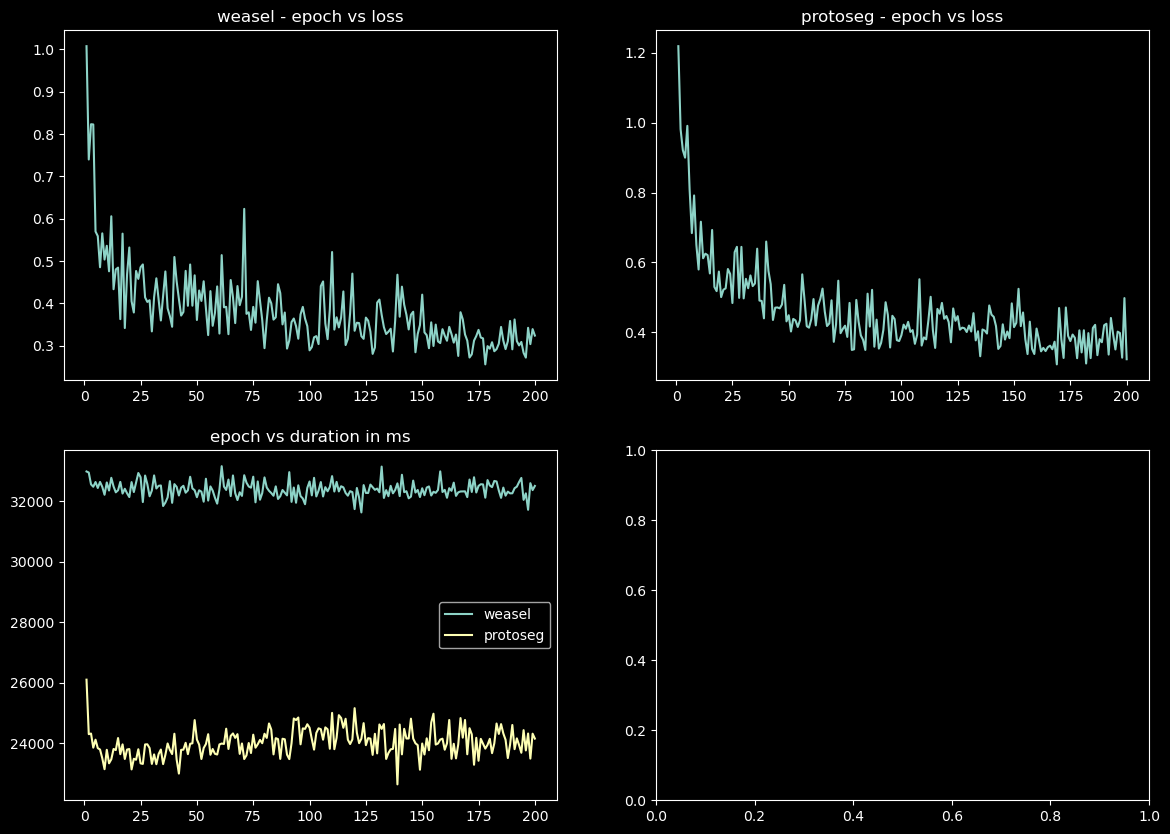

In [2]:
weasel_train_loss = pd.read_csv('outputs/weasel_long_rimone_to_drishti/train_loss.csv')
protoseg_train_loss = pd.read_csv('outputs/protoseg_long_rimone_to_drishti/train_loss.csv')

_, axs = plt.subplots(2, 2, figsize=(14,10))

axs[0][0].set_title('weasel - epoch vs loss')
axs[0][0].plot(weasel_train_loss['epoch'], weasel_train_loss['loss'])

axs[0][1].set_title('protoseg - epoch vs loss')
axs[0][1].plot(protoseg_train_loss['epoch'], protoseg_train_loss['loss'])

axs[1][0].set_title('epoch vs duration in ms')
axs[1][0].plot(weasel_train_loss['epoch'], weasel_train_loss['duration'], label = 'weasel')
axs[1][0].plot(protoseg_train_loss['epoch'], protoseg_train_loss['duration'], label = 'protoseg')
axs[1][0].legend()

### Visualize Score

(0.0, 1.0)

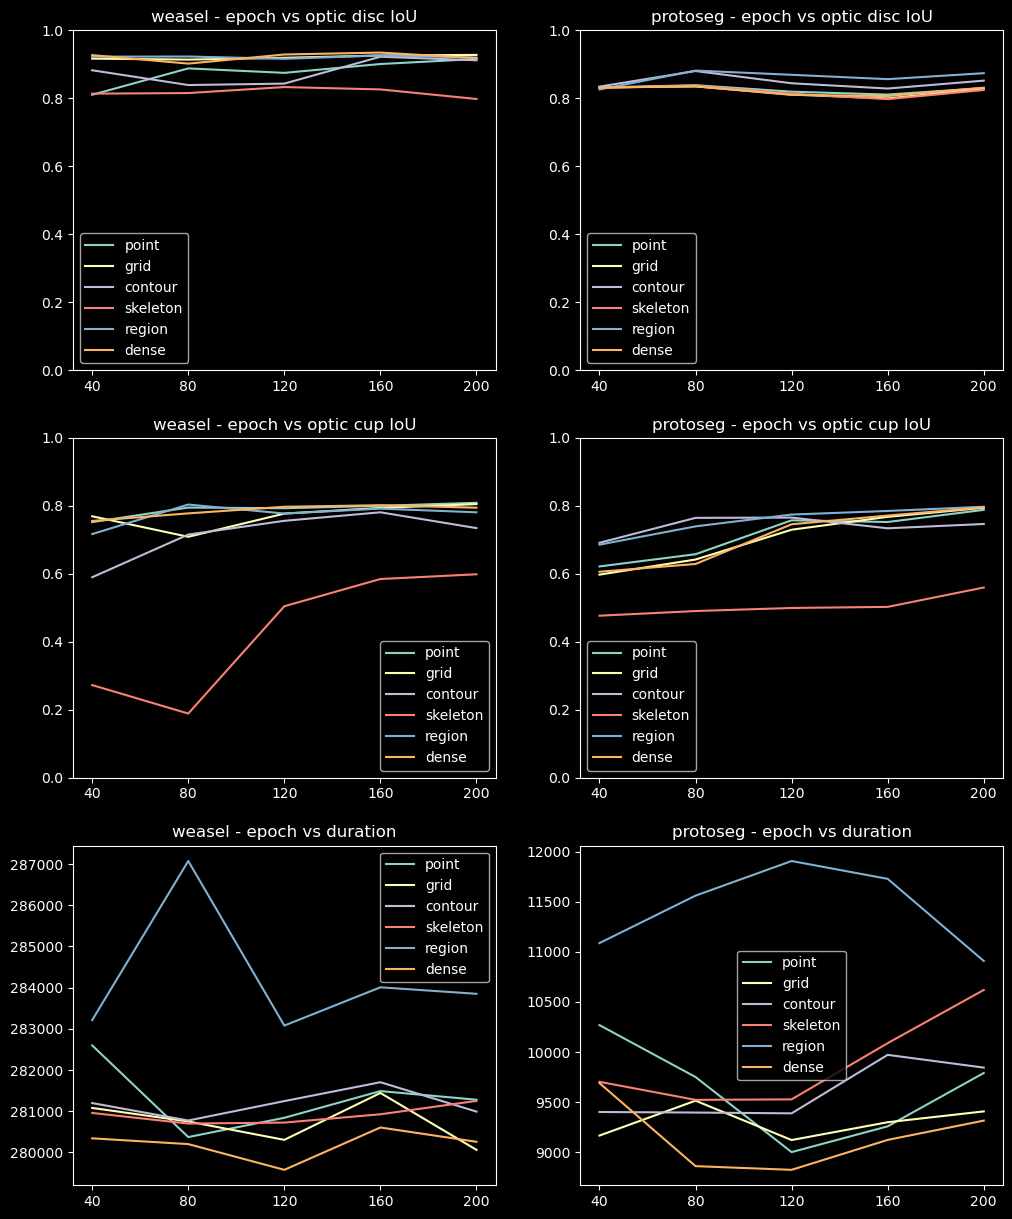

In [9]:
weasel_tuned_score = pd.read_csv('outputs/weasel_long_rimone_to_drishti/tuned_score.csv')
protoseg_tuned_score = pd.read_csv('outputs/protoseg_long_rimone_to_drishti/tuned_score.csv')

sparsity_modes = ['point', 'grid', 'contour', 'skeleton', 'region', 'dense']

_, axs = plt.subplots(3, 2, figsize=(12,15))

for sm in sparsity_modes:
    weasel_df = weasel_tuned_score[weasel_tuned_score['sparsity_mode'] == sm]
    weasel_epochs = [str(ep) for ep in weasel_df['epoch']]
    axs[0][0].plot(weasel_epochs, weasel_df['iou_od'], label = sm)
    axs[1][0].plot(weasel_epochs, weasel_df['iou_oc'], label = sm)
    axs[2][0].plot(weasel_epochs, weasel_df['duration'], label = sm)

    protoseg_df = protoseg_tuned_score[protoseg_tuned_score['sparsity_mode'] == sm]
    protoseg_epochs = [str(ep) for ep in protoseg_df['epoch']]
    axs[0][1].plot(protoseg_epochs, protoseg_df['iou_od'], label = sm)
    axs[1][1].plot(protoseg_epochs, protoseg_df['iou_oc'], label = sm)
    axs[2][1].plot(protoseg_epochs, protoseg_df['duration'], label = sm)

axs[0][0].set_title('weasel - epoch vs optic disc IoU')
axs[1][0].set_title('weasel - epoch vs optic cup IoU')
axs[2][0].set_title('weasel - epoch vs duration')
axs[0][0].legend()
axs[1][0].legend()
axs[2][0].legend()
axs[0][0].set_ylim([0, 1])
axs[1][0].set_ylim([0, 1])
axs[0][1].set_title('protoseg - epoch vs optic disc IoU')
axs[1][1].set_title('protoseg - epoch vs optic cup IoU')
axs[2][1].set_title('protoseg - epoch vs duration')
axs[0][1].legend()
axs[1][1].legend()
axs[2][1].legend()
axs[0][1].set_ylim([0, 1])
axs[1][1].set_ylim([0, 1])

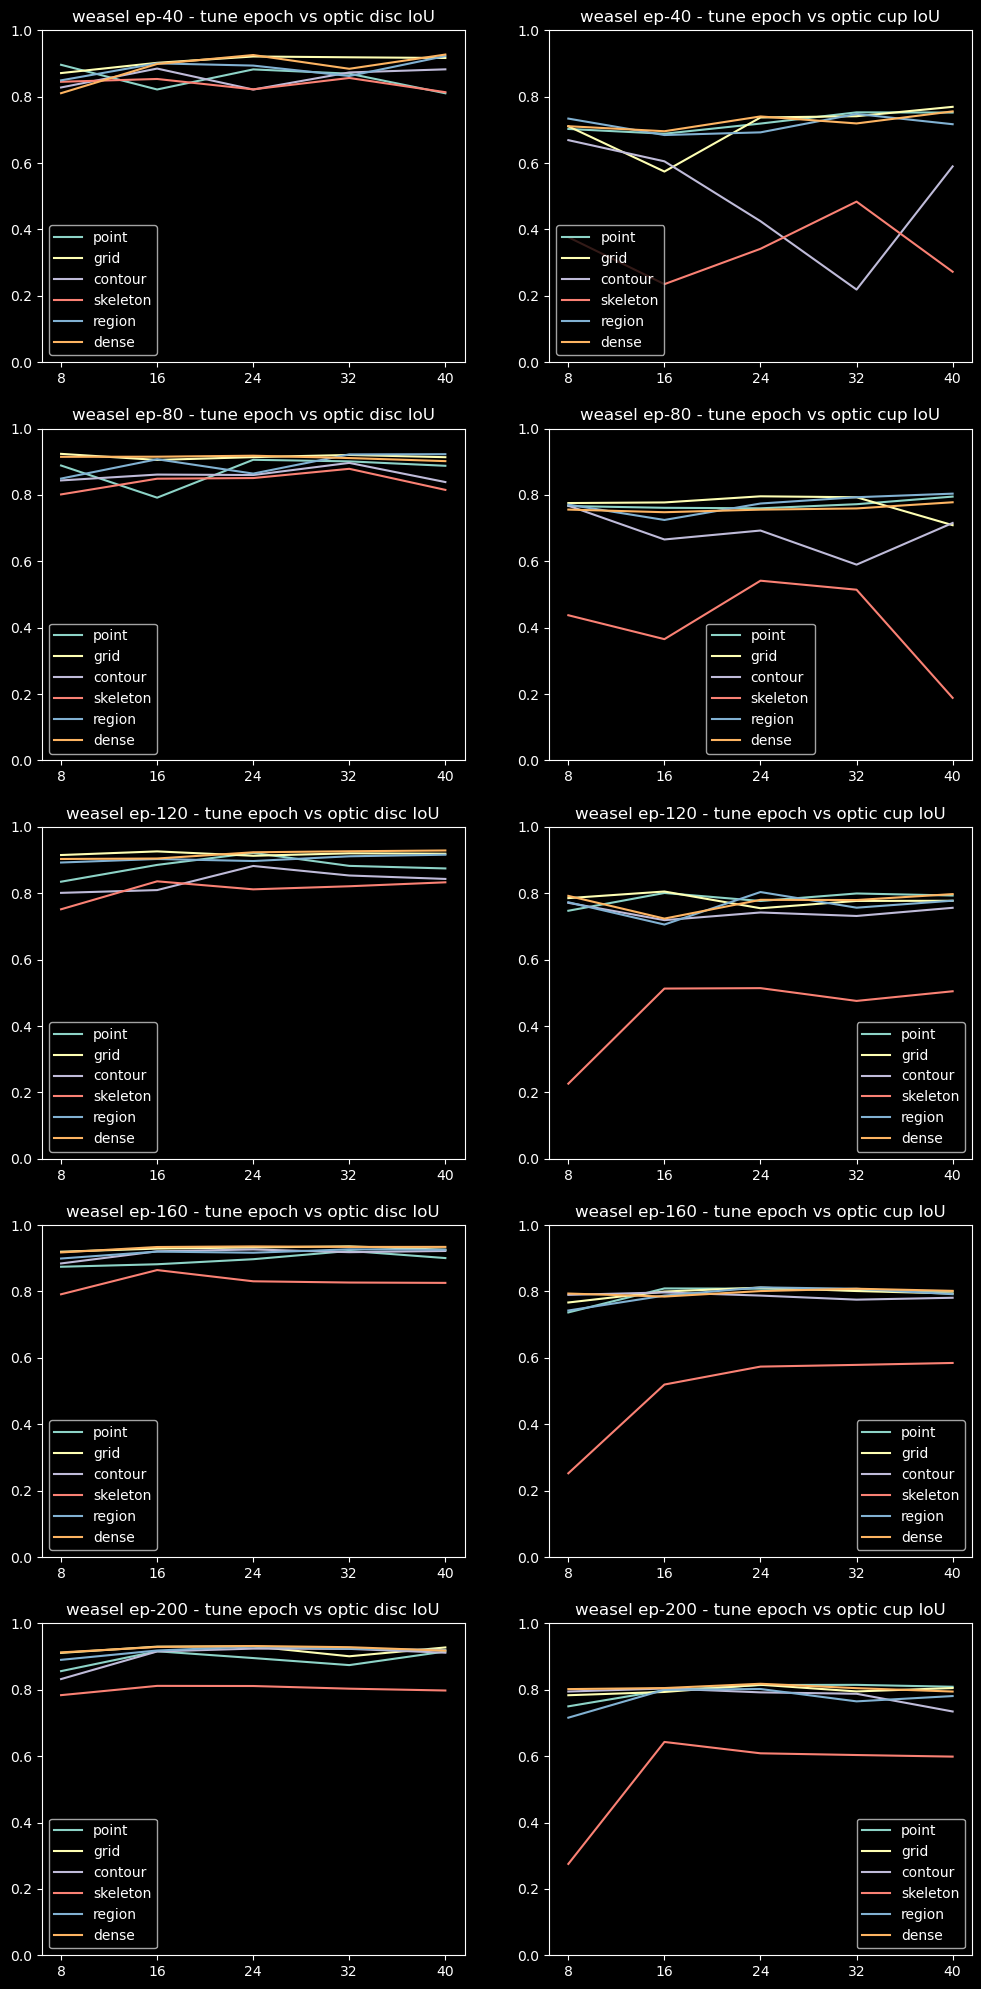

In [7]:
weasel_tuning_score = pd.read_csv('outputs/weasel_long_rimone_to_drishti/tuning_score.csv')
weasel_epochs = weasel_tuning_score['epoch'].unique()

sparsity_modes = ['point', 'grid', 'contour', 'skeleton', 'region', 'dense']

_, axs = plt.subplots(len(weasel_epochs), 2, figsize=(12,5*len(weasel_epochs)))

for i, ep in enumerate(weasel_epochs):
    for sm in sparsity_modes:
        weasel_df = weasel_tuning_score[(weasel_tuning_score['sparsity_mode'] == sm) & (weasel_tuning_score['epoch'] == ep)]
        weasel_tune_epochs = [str(tep) for tep in weasel_df['tune_epoch']]
        axs[i][0].plot(weasel_tune_epochs, weasel_df['iou_od'], label = sm)
        axs[i][1].plot(weasel_tune_epochs, weasel_df['iou_oc'], label = sm)
        # axs[i][2].plot(weasel_tune_epochs, weasel_df['test_duration'], label = sm)

    axs[i][0].set_title(f'weasel ep-{ep} - tune epoch vs optic disc IoU')
    axs[i][1].set_title(f'weasel ep-{ep} - tune epoch vs optic cup IoU')
    # axs[i][2].set_title(f'weasel ep-{ep} - tune epoch vs test duration')
    axs[i][0].legend()
    axs[i][1].legend()
    # axs[i][2].legend()
    axs[i][0].set_ylim([0, 1])
    axs[i][1].set_ylim([0, 1])

## Sparsification

[0 1 2] [False  True] [False  True]


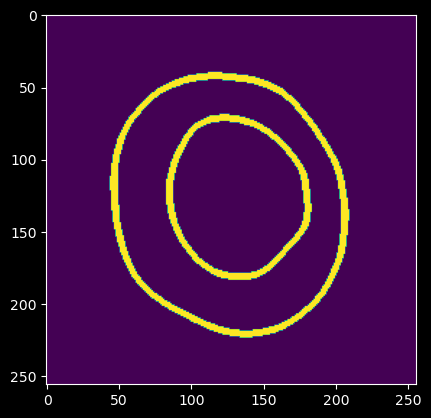

In [78]:
from skimage import feature, morphology

edge_mask = feature.canny(mask.astype(np.float64))
edge_mask_dilated = morphology.binary_dilation(edge_mask, footprint=morphology.disk(2))

print(np.unique(mask), np.unique(edge_mask), np.unique(edge_mask_dilated))
plt.imshow(edge_mask_dilated)

## File Processing

### Clean Mixed Print and Log

In [29]:
# log_file_ori = open('outputs/protoseg_long_rimone_to_drishti/learn_log_ori.txt', 'r')
# log_file = open('outputs/protoseg_long_rimone_to_drishti/learn_log.txt', 'w')
# 
# for i in range(1, 4900):
#     line = log_file_ori.readline()
#     
#     if not line.startswith('INFO'):
#         continue
#     
#     log_file.write(line.removeprefix('INFO:root:'))
# 
# log_file_ori.close()
# log_file.close()

### Change Exp Name

In [1]:
import json, os

def change_exp_name(old_name: str, new_name: str, output_path: str, checkpoint_path: str, config_filename: str) -> None:
    os.rename(os.path.join(output_path, old_name), os.path.join(output_path, new_name))
    os.rename(os.path.join(checkpoint_path, old_name), os.path.join(checkpoint_path, new_name))

    config_filepath = os.path.join(output_path, new_name, config_filename)
    with open(config_filepath, 'r') as config_file:
        config: AllConfig = json.load(config_file)
        
    config['learn']['exp_name'] = new_name
    with open(config_filepath, 'w') as config_file:
        json.dump(config, config_file, indent=4)

In [3]:
# change_exp_name('PS RO-DR short v2 proper-split', 'PS RO-DR short v2- proper-split', 'outputs', 'ckpt', 'config.json')

for exp_name in filter(lambda x: 'v2-' in x, os.listdir('outputs')):
    change_exp_name(exp_name, exp_name.replace('v2-', 'v2'), 'outputs', 'ckpt', 'config.json')

## GPU Usage

In [45]:
import torch

print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_reserved(0))
print(torch.cuda.memory_allocated(0))
print(torch.cuda.memory_stats(0))

2147352576
0
0
OrderedDict([('active.all.allocated', 0), ('active.all.current', 0), ('active.all.freed', 0), ('active.all.peak', 0), ('active.large_pool.allocated', 0), ('active.large_pool.current', 0), ('active.large_pool.freed', 0), ('active.large_pool.peak', 0), ('active.small_pool.allocated', 0), ('active.small_pool.current', 0), ('active.small_pool.freed', 0), ('active.small_pool.peak', 0), ('active_bytes.all.allocated', 0), ('active_bytes.all.current', 0), ('active_bytes.all.freed', 0), ('active_bytes.all.peak', 0), ('active_bytes.large_pool.allocated', 0), ('active_bytes.large_pool.current', 0), ('active_bytes.large_pool.freed', 0), ('active_bytes.large_pool.peak', 0), ('active_bytes.small_pool.allocated', 0), ('active_bytes.small_pool.current', 0), ('active_bytes.small_pool.freed', 0), ('active_bytes.small_pool.peak', 0), ('allocated_bytes.all.allocated', 0), ('allocated_bytes.all.current', 0), ('allocated_bytes.all.freed', 0), ('allocated_bytes.all.peak', 0), ('allocated_bytes

In [8]:
nvidia_smi_text = b'Thu Dec 21 07:17:44 2023       \n+-----------------------------------------------------------------------------+\n| NVIDIA-SMI 450.191.01   Driver Version: 450.191.01   CUDA Version: 11.0     |\n|-------------------------------+----------------------+----------------------+\n| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |\n| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |\n|                               |                      |               MIG M. |\n|===============================+======================+======================|\n|   0  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |\n| N/A   44C    P0   199W / 300W |  10256MiB / 32510MiB |     51%      Default |\n|                               |                      |                  N/A |\n+-------------------------------+----------------------+----------------------+\n                                                                               \n+-----------------------------------------------------------------------------+\n| Processes:                                                                  |\n|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |\n|        ID   ID                                                   Usage      |\n|=============================================================================|\n+-----------------------------------------------------------------------------+\n'

# extract memory usage and available memory


In [34]:
import re

# command = 'nvidia-smi'
# nvidia_smi_text = subprocess.check_output(command)
[used_ram, total_ram] = re.findall(r'\b\d+MiB', str(nvidia_smi_text))
used_ram = int(used_ram[:-3])
total_ram = int(total_ram[:-3])
percent_ram = used_ram * 100 / total_ram

percent_ram, total_ram

(0.0, 2048)

## Other